In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

2023-12-28 16:49:38.783537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 16:49:38.783576: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 16:49:38.785204: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 16:49:38.931688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow Version:  2.14.0
Numpy version:  1.26.1
Pandas version:  2.1.1
Scikit-learn version:  1.3.1


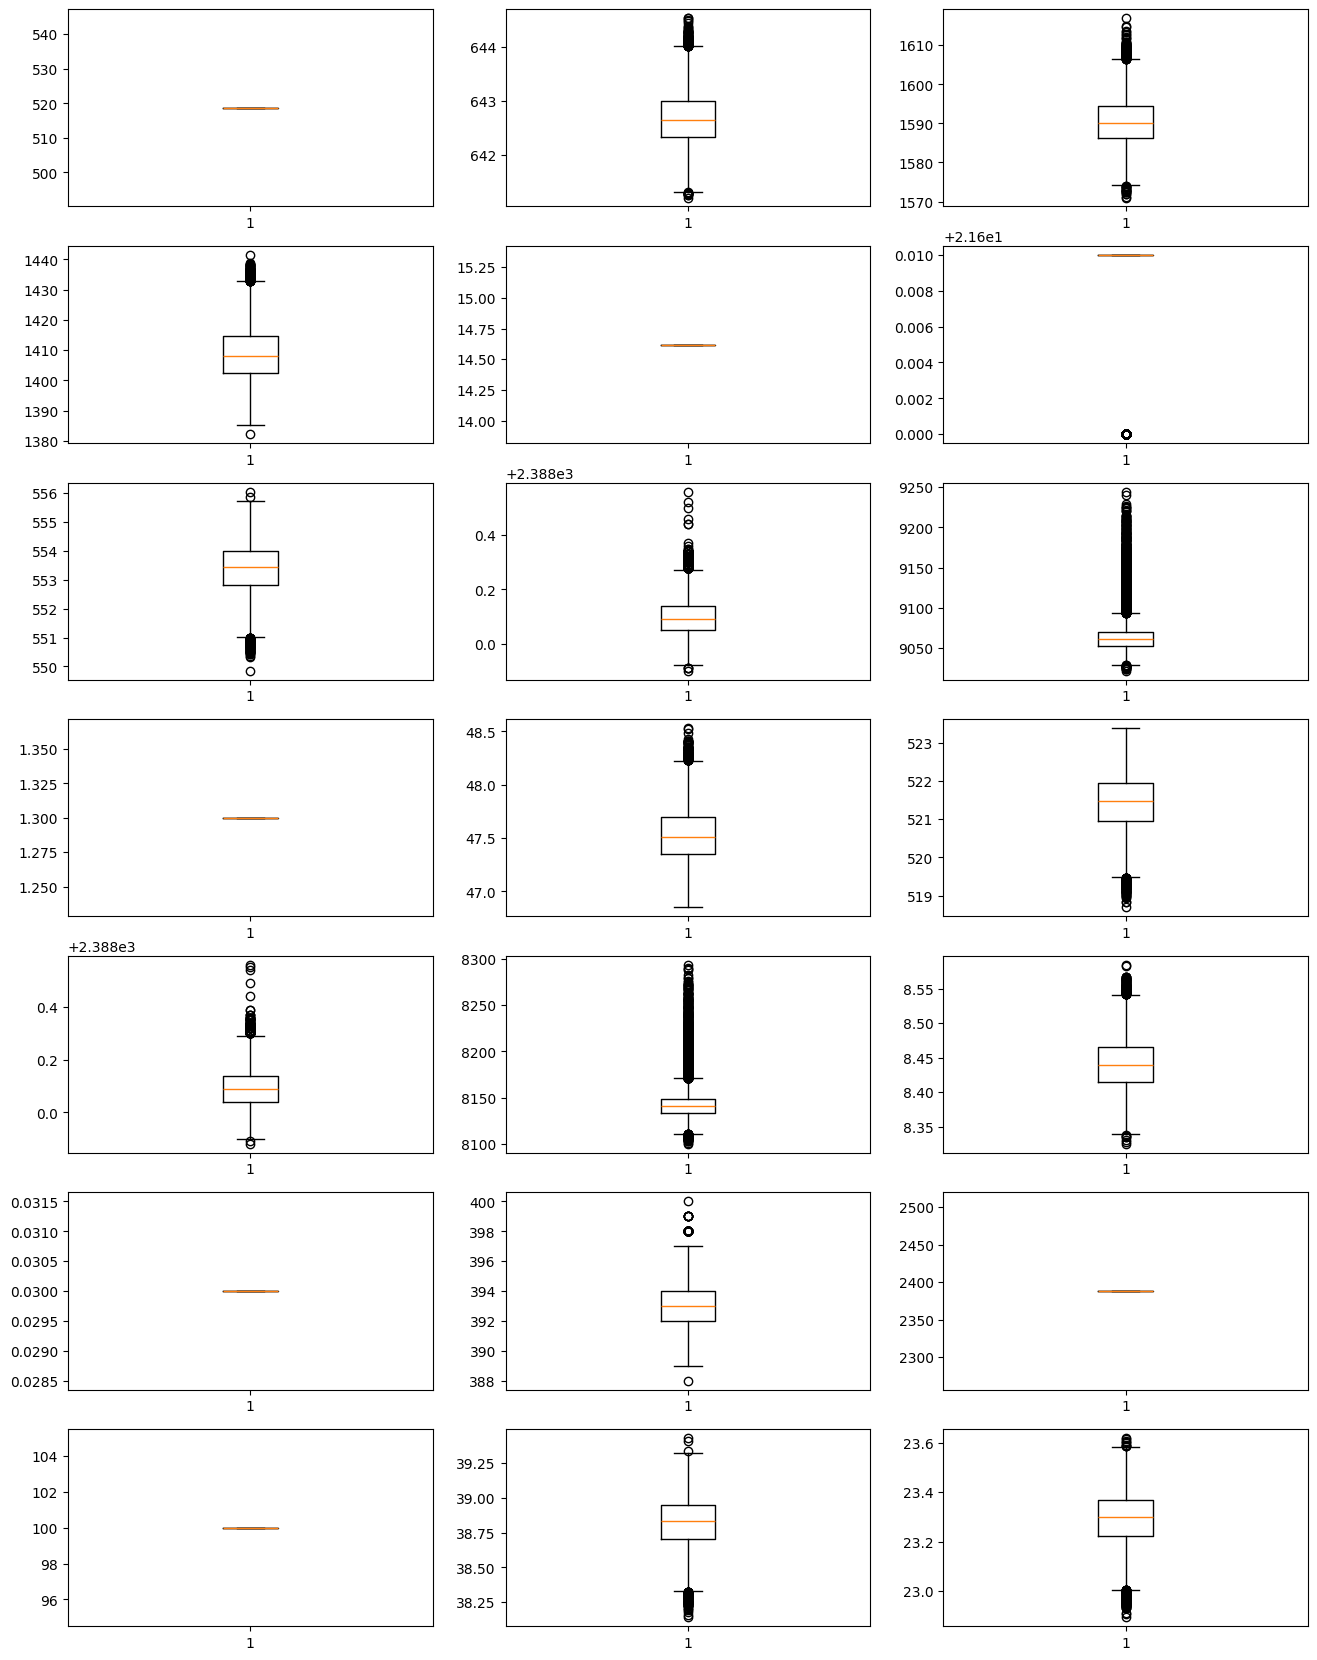

In [3]:
train_data = pd.read_csv("../CMAPSS/train_FD001.txt", sep= "\s+", header = None)
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train_data.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
plt.show()

In [4]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [5]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [6]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [7]:
test_data = pd.read_csv("../CMAPSS/test_FD001.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("../CMAPSS/RUL_FD001.txt", sep = '\s+', header = None)

window_length = 30 #corretta
shift = 1 #corretta
early_rul = 125        #corretta    
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

print(type(processed_train_data))
print(type(processed_test_data))
print(type(processed_train_targets))
print(type(true_rul))

np.save("processed_test_data_np",processed_test_data)
np.save("processed_test_RUL_np", true_rul)

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 14)
Processed validation data shape:  (3547, 30, 14)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


In [9]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [10]:
def custom_loss(y_true, y_pred):
    alpha = 0.2
    difference = y_pred - y_true
    squared_difference = tf.square(y_pred - y_true)
    
    # Calcola la loss per ciascun elemento
    loss = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
    
    # Calcola la media delle loss
    return tf.reduce_mean(loss)

In [11]:
def create_compiled_model():
    model = Sequential([
        layers.Conv(128, input_shape = (window_length, 14), return_sequences=True, activation = "tanh"),
        layers.LSTM(64, activation = "tanh", return_sequences = True),
        layers.LSTM(32, activation = "tanh"),
        layers.Dense(96, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [12]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
def create_CNN_small(): 
    cnn_small = Sequential(
        [
            layers.Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(30, 14)),
            layers.Conv1D(filters=32, kernel_size=6, activation='relu'),
            layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
            layers.MaxPooling1D(pool_size=2),
            layers.Flatten(), 
            layers.Dense(units=32, activation='relu'),
            layers.Dense(units=1, activation='linear')
        ]
    )

    cnn_small.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=custom_loss)
    return cnn_small

cnn_small = create_CNN_small()

2023-12-28 16:49:44.433827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-28 16:49:44.464626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-28 16:49:44.464932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
EPOCHS = 80 #150 per la large
BATCH_SIZE = 256 #512 per la large


history = cnn_small.fit(processed_train_data, 
                             processed_train_targets, 
                        epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets), 
                     batch_size=BATCH_SIZE)

Epoch 1/80


2023-12-28 16:49:45.609382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-28 16:49:45.895716: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-28 16:49:46.162671: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-28 16:49:47.094831: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5705182a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-28 16:49:47.094873: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2023-12-28 16:49:47.106075: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-28 16:49:47.229581: I ./tensorflow/compil

56/56 [==============================] - 4s 13ms/step - loss: 673.8808 - val_loss: 400.9627
Epoch 2/80
56/56 [==============================] - 0s 7ms/step - loss: 337.6012 - val_loss: 336.3065
Epoch 3/80
56/56 [==============================] - 0s 7ms/step - loss: 273.1369 - val_loss: 230.0726
Epoch 4/80
56/56 [==============================] - 0s 7ms/step - loss: 214.9903 - val_loss: 186.4489
Epoch 5/80
56/56 [==============================] - 0s 7ms/step - loss: 205.2886 - val_loss: 172.7754
Epoch 6/80
56/56 [==============================] - 0s 6ms/step - loss: 197.6152 - val_loss: 197.2237
Epoch 7/80
56/56 [==============================] - 0s 5ms/step - loss: 193.9769 - val_loss: 169.5625
Epoch 8/80
56/56 [==============================] - 0s 5ms/step - loss: 167.4283 - val_loss: 184.1719
Epoch 9/80
56/56 [==============================] - 0s 6ms/step - loss: 187.3773 - val_loss: 153.0756
Epoch 10/80
56/56 [==============================] - 0s 7ms/step - loss: 167.1258 - val_loss

In [14]:
rul_pred = cnn_small.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE (LARGE MODEL MSE): ", RMSE)

16/16 [==============================] - 0s 7ms/step
RMSE (LARGE MODEL MSE):  18.709037518750094


In [15]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  18.67032979386374


In [16]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score (SMALL MODEL MSE): ", s_score)

S-score (LARGE MODEL MSE):  781.1996133186675


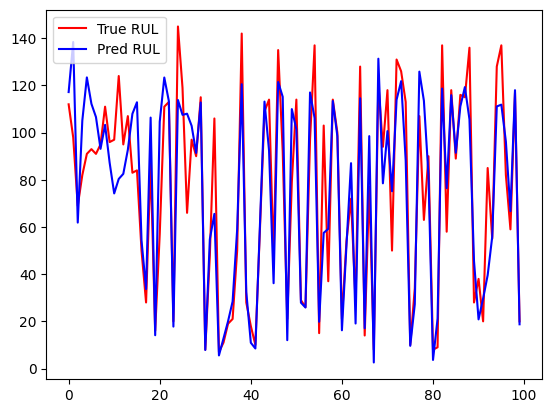

In [17]:
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [18]:
def create_CNN_large(): 
    cnn_small = Sequential(
        [
            layers.Conv1D(filters=128, kernel_size=8, activation='relu', input_shape=(30, 14)),
            layers.Conv1D(filters=64, kernel_size=6, activation='relu'),
            layers.Conv1D(filters=32, kernel_size=4, activation='relu'),
            layers.Conv1D(filters=16, kernel_size=2, activation='relu'),
            layers.MaxPooling1D(pool_size=2),
            layers.Flatten(), 
            layers.Dense(units=32, activation='relu'),
            layers.Dense(units=1, activation='linear')
        ]
    )

    cnn_small.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=custom_loss)
    return cnn_small

cnn_large = create_CNN_large()

In [19]:
EPOCHS = 150 #150 per la large
BATCH_SIZE = 512 #512 per la large


history = cnn_large.fit(processed_train_data, 
                             processed_train_targets, 
                        epochs = EPOCHS, 
                     validation_data = (processed_val_data, processed_val_targets), 
                     batch_size=BATCH_SIZE)

Epoch 1/150
28/28 [==============================] - 2s 23ms/step - loss: 1925.1964 - val_loss: 622.3721
Epoch 2/150
28/28 [==============================] - 0s 9ms/step - loss: 456.7649 - val_loss: 385.6024
Epoch 3/150
28/28 [==============================] - 0s 9ms/step - loss: 368.4979 - val_loss: 352.2886
Epoch 4/150
28/28 [==============================] - 0s 9ms/step - loss: 338.7896 - val_loss: 331.8091
Epoch 5/150
28/28 [==============================] - 0s 9ms/step - loss: 298.2495 - val_loss: 268.2266
Epoch 6/150
28/28 [==============================] - 0s 9ms/step - loss: 245.4940 - val_loss: 288.3551
Epoch 7/150
28/28 [==============================] - 0s 9ms/step - loss: 226.7479 - val_loss: 225.5671
Epoch 8/150
28/28 [==============================] - 0s 9ms/step - loss: 203.4291 - val_loss: 202.9789
Epoch 9/150
28/28 [==============================] - 0s 9ms/step - loss: 219.7485 - val_loss: 203.8077
Epoch 10/150
28/28 [==============================] - 0s 8ms/step - los

In [21]:
rul_pred = cnn_large.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE (LARGE MODEL MSE): ", RMSE)

16/16 [==============================] - 0s 9ms/step
RMSE (LARGE MODEL MSE):  18.826319447463717


In [23]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  19.53193408392033


In [25]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score (SMALL MODEL MSE): ", s_score)

S-score (SMALL MODEL MSE):  858.0071167792161


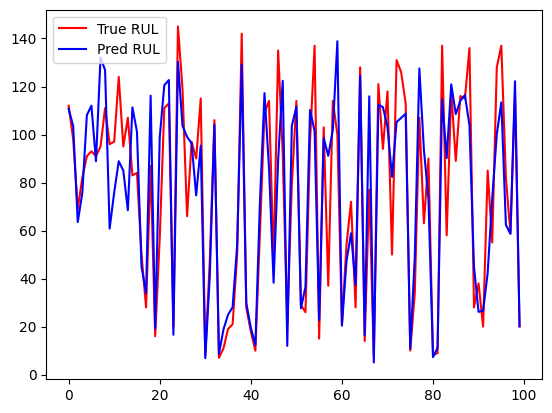

In [26]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()



In [27]:
def create_compiled_model():
    model = Sequential([
        layers.Conv1D(256, 7, activation = "relu", input_shape = (window_length, processed_train_data.shape[2])),
        layers.Conv1D(96, 7, activation = "relu"),
        layers.Conv1D(32, 7, activation = "relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [28]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001


In [29]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [30]:
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 30,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 64, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/30
222/222 - 4s - loss: 916.8909 - val_loss: 420.0094 - lr: 0.0010 - 4s/epoch - 17ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/30
222/222 - 1s - loss: 359.7735 - val_loss: 305.4155 - lr: 0.0010 - 1s/epoch - 7ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/30
222/222 - 1s - loss: 305.4124 - val_loss: 271.3907 - lr: 0.0010 - 1s/epoch - 7ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/30
222/222 - 1s - loss: 284.0256 - val_loss: 274.3517 - lr: 0.0010 - 1s/epoch - 7ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/30
222/222 - 2s - loss: 268.1538 - val_loss: 352.9097 - lr: 0.0010 - 2s/epoch - 7ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/30
222/222 - 1s - loss: 268.6679 - val_loss: 236.4494 - lr: 0.0010 - 1s/epoch - 7ms/step

Epoch 7: LearningRateScheduler s

In [31]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)


16/16 [==============================] - 0s 7ms/step
RMSE:  16.018870807799694


In [32]:
ndices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  15.923190709807049


In [33]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)


S-score:  440.93349567616735


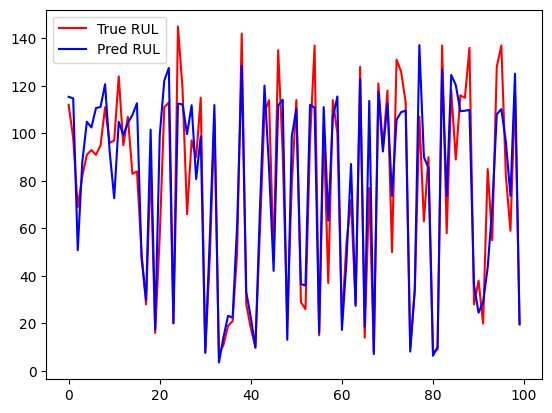

In [34]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()



In [35]:
from tflite_converter import convert_to_tflite
## Saving the models

MODEL_DIR = './models/FD001/CNNsmall'
BATCH_SIZE = 1
STEPS = 30 
INPUT_SIZE = 14
nome = "CNN_small_batch_1"
convert_to_tflite(MODEL_DIR, BATCH_SIZE, STEPS, INPUT_SIZE, cnn_small, nome)

INFO:tensorflow:Assets written to: ./models/FD001/CNNsmall/assets


INFO:tensorflow:Assets written to: ./models/FD001/CNNsmall/assets
2023-12-28 17:05:58.872216: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-28 17:05:58.872250: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-28 17:05:58.872889: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ./models/FD001/CNNsmall
2023-12-28 17:05:58.873969: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-28 17:05:58.873980: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: ./models/FD001/CNNsmall
2023-12-28 17:05:58.876271: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-12-28 17:05:58.877397: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-28 17:05:58.917138: I tensorflow/cc/saved_model/loader.cc:217] 

In [36]:

MODEL_DIR = './models/FD001/CNNlarge'
BATCH_SIZE = 1
STEPS = 30 
INPUT_SIZE = 14
nome = "CNN_large_batch_1"
convert_to_tflite(MODEL_DIR, BATCH_SIZE, STEPS, INPUT_SIZE, cnn_large, nome)

INFO:tensorflow:Assets written to: ./models/FD001/CNNlarge/assets


INFO:tensorflow:Assets written to: ./models/FD001/CNNlarge/assets
2023-12-28 17:06:02.718187: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-28 17:06:02.718228: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-28 17:06:02.718427: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ./models/FD001/CNNlarge
2023-12-28 17:06:02.720509: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-28 17:06:02.720543: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: ./models/FD001/CNNlarge
2023-12-28 17:06:02.725019: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-28 17:06:02.774245: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: ./models/FD001/CNNlarge
2023-12-28 17:06:02.788700: I tensorflow/cc/saved_mod